In [5]:
import sys
sys.path.append('/media/data/hungnt/work/Datasets/BTMD/Code/src')

import os
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns

from utils import make_ndarray_from_csv, get_int_label
from collections import Counter, OrderedDict
from matplotlib import rcParams
from imblearn.over_sampling import SMOTE, RandomOverSampler

## Config

In [6]:
# Change option so that pandas always display all rows of the dataframe
pd.set_option('display.max_rows', None)

In [7]:
TAKE_MINOR_AT = -5
fold = '1.0'

## Count number of samples for each class

In [8]:
features, labels = make_ndarray_from_csv(fold, mode = 'train')
features.shape, labels.shape

((2204, 10000), (2204,))

In [9]:
labels_count = Counter(labels)

In [10]:
print(labels_count)

Counter({'Embryonal': 481, 'Glioblastoma': 336, 'Ependymal': 270, 'Other glioma': 257, 'Glioma IDH': 162, 'Glio-neuronal': 154, 'Mesenchymal': 132, 'Sella': 132, 'Control': 92, 'Plexus': 65, 'Pineal': 62, 'Nerve': 24, 'Melanocytic': 21, 'Haematopoietic': 16})


In [11]:
sorted_labels_count = OrderedDict(labels_count.most_common())
print(sorted_labels_count)

OrderedDict([('Embryonal', 481), ('Glioblastoma', 336), ('Ependymal', 270), ('Other glioma', 257), ('Glioma IDH', 162), ('Glio-neuronal', 154), ('Mesenchymal', 132), ('Sella', 132), ('Control', 92), ('Plexus', 65), ('Pineal', 62), ('Nerve', 24), ('Melanocytic', 21), ('Haematopoietic', 16)])


In [12]:
df = pd.DataFrame.from_dict(sorted_labels_count, orient='index').reset_index()
df = df.rename(columns = {'index':'labels', 0:'samples'})
print(df.to_string())
# df

            labels  samples
0        Embryonal      481
1     Glioblastoma      336
2        Ependymal      270
3     Other glioma      257
4       Glioma IDH      162
5    Glio-neuronal      154
6      Mesenchymal      132
7            Sella      132
8          Control       92
9           Plexus       65
10          Pineal       62
11           Nerve       24
12     Melanocytic       21
13  Haematopoietic       16


## Visualization

In [13]:
classes = np.array(df.iloc[:,0])
n_samples = np.array(df.iloc[:,-1])
counts = df['labels'].value_counts().reset_index(name = 'samples')
print(labels.shape, n_samples.shape)

(2204,) (14,)


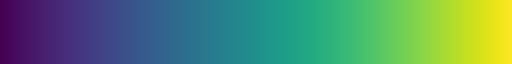

In [14]:
sns.set(font_scale=1)
# test color for sns graph pallette
'''
Possible palette values include:
Name of a seaborn palette (deep, muted, bright, pastel, dark, colorblind)

Name of matplotlib colormap (check here: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html)

‘husl’ or ‘hls’

‘ch:<cubehelix arguments>’

‘light:<color>’, ‘dark:<color>’, ‘blend:<color>,<color>’,

A sequence of colors in any format matplotlib accepts
'''
graph_palette = "viridis"
sns.color_palette(graph_palette, as_cmap=True)

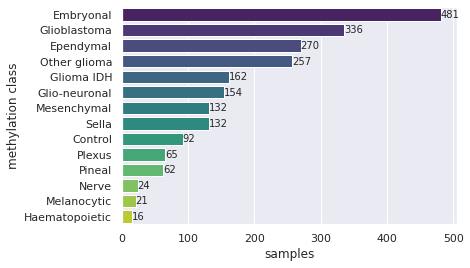

In [15]:
rcParams['figure.figsize'] = 20, 10
graph = sns.barplot(x = n_samples, y = classes, data = counts, palette = graph_palette)
graph.bar_label(graph.containers[0])
graph.set_xlabel("samples")
graph.set_ylabel("methylation class")
plt.show()

## Tackle the imbalanced class distribution

#### SMOTE

In [16]:
X = features
y = labels
print(np.unique(labels))
print(np.unique(y))

['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Haematopoietic' 'Melanocytic' 'Mesenchymal' 'Nerve'
 'Other glioma' 'Pineal' 'Plexus' 'Sella']
['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Haematopoietic' 'Melanocytic' 'Mesenchymal' 'Nerve'
 'Other glioma' 'Pineal' 'Plexus' 'Sella']


In [17]:
minor_classes = list(sorted_labels_count.keys())[TAKE_MINOR_AT:]
print(minor_classes)

['Plexus', 'Pineal', 'Nerve', 'Melanocytic', 'Haematopoietic']


In [18]:
minor_indexes = []
i = 0
for label in labels:
    if label in minor_classes:
        minor_indexes.append(i)
    i += 1
print(len(minor_indexes))

188


In [19]:
minor_fetures = np.array([features[i] for i in minor_indexes])
minor_labels = np.array([labels[i] for i in minor_indexes])
major_features = np.array([features[i] for i in range(len(features)) if i not in minor_indexes])
major_labels = np.array([labels[i] for i in range(len(features)) if i not in minor_indexes])
print(np.unique(minor_labels), len(np.unique(minor_labels)))
print(np.unique(major_labels), len(np.unique(major_labels)))
print(len(minor_fetures), len(major_features))
print(len(minor_labels), len(major_features))

['Haematopoietic' 'Melanocytic' 'Nerve' 'Pineal' 'Plexus'] 5
['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Mesenchymal' 'Other glioma' 'Sella'] 9
188 2016
188 2016


In [20]:
X_minor = minor_fetures
y_minor = minor_labels
X_major = major_features
y_major = major_labels
print(np.unique(y_major),'\n' ,np.unique(y_minor))

['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Mesenchymal' 'Other glioma' 'Sella'] 
 ['Haematopoietic' 'Melanocytic' 'Nerve' 'Pineal' 'Plexus']


In [21]:
smote = SMOTE(sampling_strategy = "auto", random_state = 42)
new_X_minor, new_y_minor = smote.fit_resample(X_minor, y_minor)

In [22]:
print(type(new_X_minor), type(new_y_minor), len(new_X_minor), len(new_y_minor))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 325 325


In [25]:
new_X = np.append(X_major, new_X_minor, axis = 0)
new_y = np.append(y_major, new_y_minor)
print(len(new_X), len(new_y))

2341 2341
